In [53]:
from typing import List

import ncbi.datasets
from ncbi.datasets.openapi import ApiClient as DatasetsApiClient
from ncbi.datasets.openapi import ApiException as DatasetsApiException
from ncbi.datasets import GeneApi as DatasetsGeneApi

def example_usage_of_api(gene_ids: List[int]):
    if len(gene_ids) == 0:
        print("Please provide at least one gene-id")
        return

    with DatasetsApiClient() as api_client:
        gene_api = DatasetsGeneApi(api_client)

        # Get just metadata
        try:
            gene_reply = gene_api.gene_metadata_by_id(gene_ids)
            for gene in gene_reply.genes:
                print(gene.gene.gene_id)
        except DatasetsApiException as e:
            print(f"Exception when calling GeneApi: {e}\n")

        # Or, download a data package with FASTA files
        try:
            print("Begin download of data package ...")
            gene_ds_download = gene_api.download_gene_package(
                gene_ids, include_annotation_type=["FASTA_GENE", "FASTA_RNA", "FASTA_PROTEIN"], _preload_content=False
            )
            gene_reply = gene_api.gene_metadata_by_id(gene_ids)
            zipfile_name = "gene_ds_{}.zip".format(gene_ids[0])

            with open(zipfile_name, "wb") as f:
                f.write(gene_ds_download.data)
            print(f"Download completed -- see {zipfile_name}")

        except DatasetsApiException as e:
            print(f"Exception when calling GeneApi: {e}\n")


def read_fasta(fasta_str):
    if not fasta_str.strip().startswith(">"):
        print("FASTA string must have headers and headers must start with '>'")
    fasta_ls = [l.splitlines() for l in fasta_str.split(">")[1:]]
    fasta_dict = {header: "".join(seq) for header,*seq in fasta_ls}
    return fasta_dict

# Look up the symbols, chromosome number and SwissProt accession for each gene
def report_on_gene_descriptors(gene_summary, leader='\t', report_errors=True):
    if report_errors:
        for message in gene_summary.messages or []:
            print(f'{leader}Error for: ({",".join(message.error.invalid_identifiers)})')
            print(f'{leader}{leader}Reason: ({message.error.reason})')

    if not gene_summary.genes:
        print(f'{leader}No genes found')
        return

    for gene in map(lambda g: g.gene, gene_summary.genes):
        print(f'{leader}{gene.symbol} (GeneID: {gene.gene_id}), Chromosome: {gene.chromosomes}, SwissProt: {gene.swiss_prot_accessions}')


In [25]:
api_client = ncbi.datasets.ApiClient()
ds_gene_instance = ncbi.datasets.GeneApi(api_client)

gene_summary = ds_gene_instance.gene_metadata_by_id([8989])

report_on_gene_descriptors(gene_summary, leader = "- ")

- TRPA1 (GeneID: 8989), Chromosome: ['8'], SwissProt: ['O75762']


In [26]:
# Get gene id by gene symbol + organism name
gene_symbol = 'TRPA1'
gene_taxon = 'human'
gene_descriptor = ds_gene_instance.gene_metadata_by_tax_and_symbol(symbols=[gene_symbol], taxon=gene_taxon)

if not gene_descriptor.genes:
    print(f'No gene found for {gene_taxon} {gene_symbol}')
else:
    gene_id = int(gene_descriptor.genes[0].gene.gene_id)

    # Query the gene ortholog service to get all vertebrate orthologs
    ortholog_set = ds_gene_instance.gene_orthologs_by_id(gene_id=gene_id)

    if not ortholog_set.ortholog_set_id:
        print(f'\nUnable to find orthologs for gene {gene_id}')
    else:
        orthologs_descriptors = ortholog_set.genes
        report_on_gene_descriptors(orthologs_descriptors, report_errors=False)

	TRPA1 (GeneID: 100028386), Chromosome: ['3'], SwissProt: None
	TRPA1 (GeneID: 100061564), Chromosome: ['9'], SwissProt: None
	TRPA1 (GeneID: 100087634), Chromosome: ['7'], SwissProt: None
	TRPA1 (GeneID: 100152934), Chromosome: ['4'], SwissProt: None
	trpa1 (GeneID: 100158526), Chromosome: ['6'], SwissProt: None
	TRPA1 (GeneID: 100221097), Chromosome: ['2'], SwissProt: None
	TRPA1 (GeneID: 100341337), Chromosome: ['3'], SwissProt: None
	TRPA1 (GeneID: 100414472), Chromosome: ['16'], SwissProt: None
	TRPA1 (GeneID: 100460642), Chromosome: ['8'], SwissProt: None
	TRPA1 (GeneID: 100482362), Chromosome: ['9'], SwissProt: None
	Trpa1 (GeneID: 100526649), Chromosome: ['Un'], SwissProt: None
	TRPA1 (GeneID: 100545876), Chromosome: ['3'], SwissProt: None
	trpa1 (GeneID: 100556580), Chromosome: ['4'], SwissProt: None
	TRPA1 (GeneID: 100607287), Chromosome: ['16'], SwissProt: None
	TRPA1 (GeneID: 100654300), Chromosome: ['Un'], SwissProt: None
	trpa1b (GeneID: 100701720), Chromosome: ['LG9'], S

In [37]:
import pandas as pd

# extract fields of interest from descriptors class to build a table
cols = '''
common_name
taxonomic_name
symbol
type
chromosome
num_transcripts
ensembl_id
omim_id
uniprot_id
nomenclature_id
nomenclature_auth
genome_coordinates
'''
cols = cols.split('\n')[1:-1]

def _range_repr(range):
    ret = []
    for interval in range:
        ret.append(f'{interval.begin}_{interval.end}')
    return ','.join(ret)

def _ranges_repr(ranges):
    ret = []
    for range in ranges:
        ret.append(f'{range.accession_version}:{_range_repr(range.range)}')
    return ','.join(ret)

# specify genes of interest and retrieve descriptors
gene_ids = [int(g.gene.gene_id) for g in ortholog_set.genes.genes]
gene_metadata = ds_gene_instance.gene_metadata_by_id(gene_ids)

# collect elements of the descriptor class into a dictionary based on each gene ID
table_data = {}
for g in gene_metadata.genes:
    if not g.gene:
        print(f'Gene not found: {g}')
        continue
    gene = g.gene

    table_data[gene.gene_id] = [gene.common_name]
    table_data[gene.gene_id].append(gene.taxname)
    table_data[gene.gene_id].append(gene.symbol)
    table_data[gene.gene_id].append(gene.type)
    table_data[gene.gene_id].append(gene.chromosome)
    if gene.transcripts:
        table_data[gene.gene_id].append(len(gene.transcripts))
    else:
        table_data[gene.gene_id].append(0)
    table_data[gene.gene_id].append(gene.ensembl_gene_ids)
    table_data[gene.gene_id].append(gene.omim_ids)
    table_data[gene.gene_id].append(gene.swiss_prot_accessions)
    if gene.nomenclature_authority:
        table_data[gene.gene_id].append(gene.nomenclature_authority.identifier)
        table_data[gene.gene_id].append(gene.nomenclature_authority.authority)
    else:
        table_data[gene.gene_id].append(None)
        table_data[gene.gene_id].append(None)        
    table_data[gene.gene_id].append(_ranges_repr(gene.genomic_ranges))

        
df = pd.DataFrame.from_dict(table_data, orient='index', columns=cols)
df.index.name = 'gene_id'
df

,common_name,taxonomic_name,symbol,type,chromosome,num_transcripts,ensembl_id,omim_id,uniprot_id,nomenclature_id,nomenclature_auth,genome_coordinates
gene_id,,,,,,,,,,,,
100028386,gray short-tailed opossum,Monodelphis domestica,TRPA1,PROTEIN_CODING,None,2,[ENSMODG00000007215],None,None,None,None,NC_008803.1:164609682_164679614
100061564,horse,Equus caballus,TRPA1,PROTEIN_CODING,None,1,[ENSECAG00000000203],None,None,VGNC:24548,VGNC,NC_009152.3:14461430_14513101
100087634,platypus,Ornithorhynchus anatinus,TRPA1,PROTEIN_CODING,None,1,[ENSOANG00000013522],None,None,None,None,NC_041734.1:2151422_2190369
100152934,pig,Sus scrofa,TRPA1,PROTEIN_CODING,None,3,[ENSSSCG00000006186],None,None,VGNC:94459,VGNC,NC_010446.5:63493374_63558486
100158526,tropical clawed frog,Xenopus tropicalis,trpa1,PROTEIN_CODING,None,1,None,None,None,XB-GENE-1004945,Xenbase,NC_030682.2:120746375_120780978
...,...,...,...,...,...,...,...,...,...,...,...,...
474353,zebrafish,Danio rerio,trpa1b,PROTEIN_CODING,None,3,[ENSDARG00000031875],None,None,ZDB-GENE-050106-1,ZFIN,NC_007135.7:13635005_13714119
486994,dog,Canis lupus familiaris,TRPA1,PROTEIN_CODING,None,5,None,None,None,VGNC:47865,VGNC,"NC_051833.1:21050161_21102458,NC_049289.1:2110..."
505317,cattle,Bos taurus,TRPA1,PROTEIN_CODING,None,1,[ENSBTAG00000002062],None,None,VGNC:36380,VGNC,NC_037341.1:35611176_35666932


In [51]:
pd.read_json("ncbi_dataset/data/data_report.jsonl", lines = True)

,annotations,chromosomes,commonName,description,ensemblGeneIds,geneId,genomicRanges,nomenclatureAuthority,omimIds,orientation,referenceStandards,swissProtAccessions,symbol,synonyms,taxId,taxname,transcripts,type
0,[{'assembliesInScope': [{'accession': 'GCF_000...,[8],human,transient receptor potential cation channel su...,[ENSG00000104321],8989,"[{'accessionVersion': 'NC_000008.11', 'range':...","{'authority': 'HGNC', 'identifier': 'HGNC:497'}",[604775],minus,[{'geneRange': {'accessionVersion': 'NG_033890...,[O75762],TRPA1,"[FEPS, FEPS1, ANKTM1]",9606,Homo sapiens,"[{'accessionVersion': 'NM_007332.3', 'cds': {'...",PROTEIN_CODING


In [49]:


def _5prime_len(transcript):
    if not transcript.cds or not transcript.cds.range:
        return None
    return transcript.cds.range[0].begin - 1

def _3prime_len(transcript):
    if not transcript.cds or not transcript.cds.range:
        return None
    return transcript.length - transcript.cds.range[0].end

gene_report = gene_report_for(zipfile_name)

rows = []
for gene in gene_report.genes:

    # transcripts for each gene are embedded as lists and require additional handling
    for transcript in gene.transcripts:
        rows.append({
            'gene_id': gene.gene_id,
            'gene_symbol': gene.symbol,
            'gene_taxonomy': gene.taxname,            
            'accVer': transcript.accession_version,
            'name': transcript.name,
            'length': transcript.length,
            '5`UTR_len': _5prime_len(transcript),
            '3`UTR_len': _3prime_len(transcript),
            'protAccVer': transcript.protein.accession_version or None,
            'protName': transcript.protein.isoform_name or None,
            'protLength': transcript.protein.length or None,
            'exonAccVer': transcript.exons.accession_version,
            'numExons': len(transcript.exons.range),
        })

transcript_table = pd.DataFrame(rows)

transcript_table

,gene_id,gene_symbol,description,scientific_name,common_name,tax_id,genomic_range,orientation,location,gene_type,transcript_accession,transcript_name,transcript_length,transcript_cds_coords,protein_accession,isoform_name,protein_length,protein_name
0,8989,TRPA1,transient receptor potential cation channel su...,Homo sapiens,human,9606,NC_000008.11:72021250-72094885,-,chr 8,PROTEIN_CODING,NM_007332.3,NaN,5191,NM_007332.3:176-3535,NP_015628.2,NaN,1119,transient receptor potential cation channel su...
1,8989,TRPA1,transient receptor potential cation channel su...,Homo sapiens,human,9606,NC_000008.11:72021250-72094885,-,chr 8,PROTEIN_CODING,XM_011517624.2,transcript variant X1,9294,XM_011517624.2:4917-8351,XP_011515926.1,isoform X1,1144,transient receptor potential cation channel su...
2,8989,TRPA1,transient receptor potential cation channel su...,Homo sapiens,human,9606,NC_000008.11:72021250-72094885,-,chr 8,PROTEIN_CODING,XM_011517625.2,transcript variant X3,9453,XM_011517625.2:5151-8510,XP_011515927.1,isoform X2,1119,transient receptor potential cation channel su...
3,8989,TRPA1,transient receptor potential cation channel su...,Homo sapiens,human,9606,NC_000008.11:72021250-72094885,-,chr 8,PROTEIN_CODING,XM_017013946.1,transcript variant X2,5756,XM_017013946.1:1454-4813,XP_016869435.1,isoform X2,1119,transient receptor potential cation channel su...


In [ ]:
source = "ncbi_dataset/data/"
target = "data/"
for gid in gene_ids:
    example_usage_of_api([gid])

    if os.path.exists("ncbi_dataset"):
        os.system("rm -rf ncbi_dataset")
    if os.path.exists("README.md"):
        os.system("rm README.md")
    os.system(f"unzip gene_ds_{gid}.zip > /dev/null")
    for fn in ("data_report.jsonl", "gene.fna", "rna.fna", "protein.faa"):
        os.system(f"mv {source}{fn} {target}{gid}_{fn}")
    os.system(f"rm gene_ds_{gid}.zip")


In [64]:
seqs = {}

for seq_type in ("gene", "rna", "protein"):
    seqs[seq_type] = {}
    
    fns = [fn for fn in os.listdir("data") if seq_type in fn]
    
    for fn in fns:
        with open("data/" + fn) as f:
            s = "".join(f.readlines())
    
        seqs[seq_type][int(fn.split("_")[0])] = read_fasta(s)


In [92]:
all_json = ["data/"+fn for fn in os.listdir("data") if fn.endswith("jsonl")]

df = pd.concat([pd.read_json(fn, lines = True) for fn in all_json])
df.iloc[102]["transcripts"][0]

In [97]:
def _5prime_len(transcript):
    if transcript.get("cds") is None:
        return None
    if not transcript["cds"] or not transcript["cds"]["range"]:
        return None
    return int(transcript["cds"]["range"][0]["begin"]) - 1

def _3prime_len(transcript):
    if transcript.get("cds") is None:
        return None
    if not transcript["cds"] or not transcript["cds"]["range"]:
        return None
    return int(transcript["length"]) - int(transcript["cds"]["range"][0]["end"])

rows = []

for i,r in df.iterrows():
    # transcripts for each gene are embedded as lists and require additional handling
    for transcript in r.transcripts:
        rows.append({
            'gene_id': r.geneId,
            'gene_symbol': r.symbol,
            'gene_taxonomy': r.taxname,            
            'accVer': transcript["accessionVersion"],
            'name': transcript.get("name", None),
            'length': transcript["length"],
            '5`UTR_len': _5prime_len(transcript),
            '3`UTR_len': _3prime_len(transcript),
            'protAccVer': transcript.get("protein",{}).get("accessionVersion", None),
            'protName': transcript.get("protein", {}).get("isoformName", None),
            'protLength': transcript.get("protein", {}).get("length", None),
            'exonAccVer': transcript["exons"]["accessionVersion"],
            'numExons': len(transcript["exons"]["range"]),
        })

df = pd.DataFrame(rows)

In [98]:
df.head()

,gene_id,gene_symbol,gene_taxonomy,accVer,name,length,5`UTR_len,3`UTR_len,protAccVer,protName,protLength,exonAccVer,numExons
0,111156789,LOC111156789,Enhydra lutris kenyoni,XM_022517853.1,None,4110,0.0,0.0,XP_022373561.1,None,1369.0,NW_019154133.1,29
1,110197275,TRPA1,Phascolarctos cinereus,XM_020971045.1,None,3360,0.0,0.0,XP_020826704.1,None,1119.0,NW_018344163.1,27
2,116089068,Trpa1,Mastomys coucha,XM_031368800.1,transcript variant X2,4171,21.0,862.0,XP_031224660.1,isoform X2,1095.0,NW_022196896.1,26
3,116089068,Trpa1,Mastomys coucha,XM_031368799.1,transcript variant X1,4261,21.0,862.0,XP_031224659.1,isoform X1,1125.0,NW_022196896.1,27
4,108935409,trpa1b,Scleropages formosus,XM_029255039.1,None,3375,0.0,0.0,XP_029110872.1,None,1124.0,NC_041814.1,27


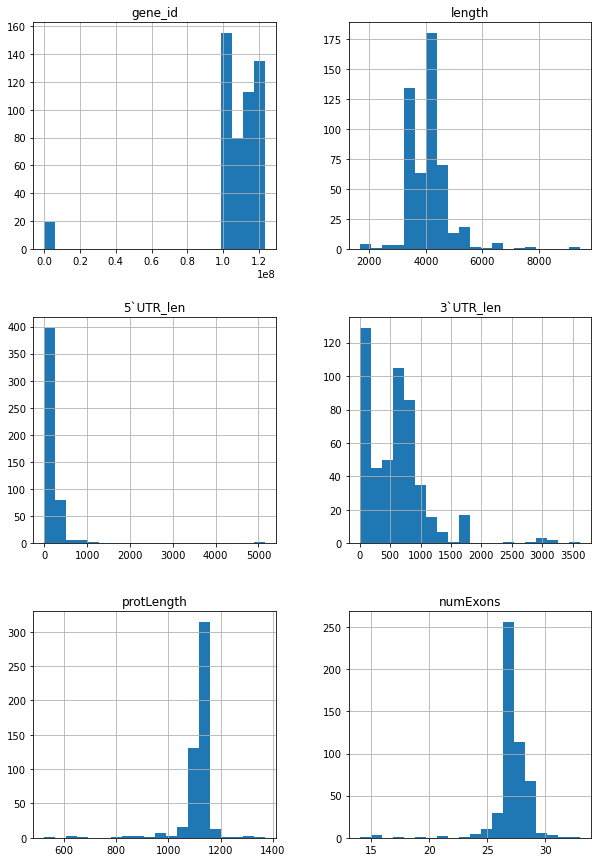

In [102]:
import matplotlib.pyplot as plt

df.hist(figsize = (10,15), bins = 20)
plt.show()